In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("Exp3_AnalysisData.xlsx")

df.info()
print(df.groupby(['Patient_ID', 'Condition']).size())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  330 non-null    object 
 1   Condition   330 non-null    object 
 2   Added_Vars  330 non-null    int64  
 3   Trial       330 non-null    int64  
 4   Risk_Score  330 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 13.0+ KB
Patient_ID  Condition
P00         Baseline     5
            add_50       5
            add_6        5
P01         Baseline     5
            add_50       5
                        ..
P20         add_50       5
            add_6        5
P21         Baseline     5
            add_50       5
            add_6        5
Length: 66, dtype: int64


In [4]:
df.head()

,Patient_ID,Condition,Added_Vars,Trial,Risk_Score
0,P00,Baseline,0,1,4.5
1,P00,Baseline,0,2,5.0
2,P00,Baseline,0,3,5.0
3,P00,Baseline,0,4,5.0
4,P00,Baseline,0,5,5.0


In [12]:
# Calculate mean baseline per patient
baseline_means = df[df["Condition"] == "Baseline"].groupby("Patient_ID")["Risk_Score"].mean().rename("Baseline_Risk")

# Merge baseline back into the main DataFrame
df = df.merge(baseline_means, on="Patient_ID", how="left")

# Compute absolute delta risk
df["Abs_Delta_Risk"] = (df["Risk_Score"] - df["Baseline_Risk"]).abs()
df.head()


,Patient_ID,Condition,Added_Vars,Trial,Risk_Score,Baseline_Risk,Abs_Delta_Risk
0,P00,Baseline,0,1,4.5,4.9,0.4
1,P00,Baseline,0,2,5.0,4.9,0.1
2,P00,Baseline,0,3,5.0,4.9,0.1
3,P00,Baseline,0,4,5.0,4.9,0.1
4,P00,Baseline,0,5,5.0,4.9,0.1


In [7]:
model = smf.mixedlm("Abs_Delta_Risk ~ Added_Vars", df, groups=df["Patient_ID"])
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Abs_Delta_Risk
No. Observations: 330     Method:             REML          
No. Groups:       22      Scale:              1.1230        
Min. group size:  15      Log-Likelihood:     -499.1709     
Max. group size:  15      Converged:          Yes           
Mean group size:  15.0                                      
-------------------------------------------------------------
                Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       0.845     0.091  9.265  0.000   0.666   1.024
Added_Vars      0.020     0.003  7.460  0.000   0.014   0.025
Group Var       0.056     0.039                              



In [10]:
summary = df.groupby("Condition").agg(
    Mean_Risk=("Risk_Score", "mean"),
    SE_Risk=("Risk_Score", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

print(summary)

  Condition  Mean_Risk   SE_Risk
0  Baseline   6.824545  0.193321
1    add_50   5.862273  0.191401
2     add_6   6.785455  0.201553


/var/folders/z_/5vjxj12n6l1_lx8vl9hfs5h80000gn/T/ipykernel_74089/3517093182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


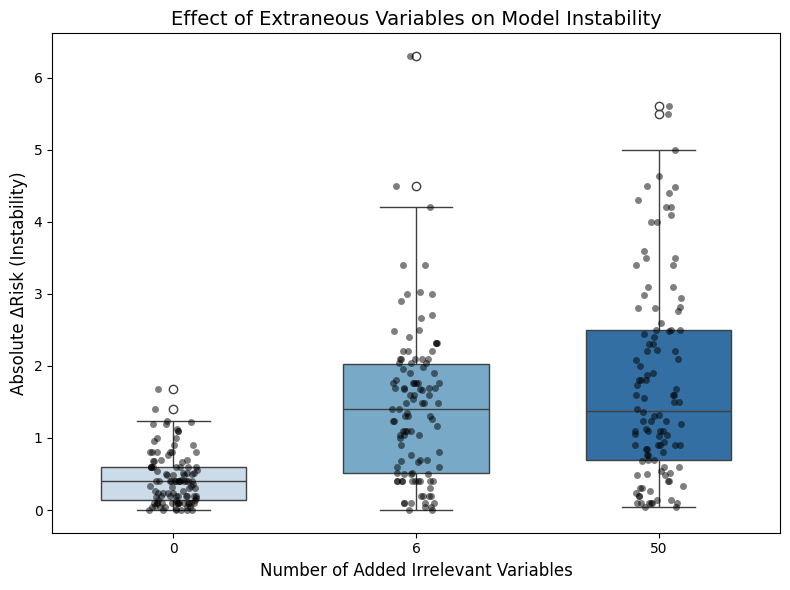

In [13]:

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="Added_Vars",
    y="Abs_Delta_Risk",
    palette="Blues",
    width=0.6
)

sns.stripplot(
    data=df,
    x="Added_Vars",
    y="Abs_Delta_Risk",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.title("Effect of Extraneous Variables on Model Instability", fontsize=14)
plt.xlabel("Number of Added Irrelevant Variables", fontsize=12)
plt.ylabel("Absolute ΔRisk (Instability)", fontsize=12)
plt.tight_layout()
plt.show()


*There's not much of change from 1 to 6 to 50 --> potential reasons could be that "risk" and "protective" factors for more nonsensical variables will cancel eachother out, another explanation could be that the range as you add more variables becomes wider. Lots to look into here. implications-- what does this mean for utilizing LLMs in this case? Can I look at attribution entropy with the data I have. WHat does the general trend seem to look like?

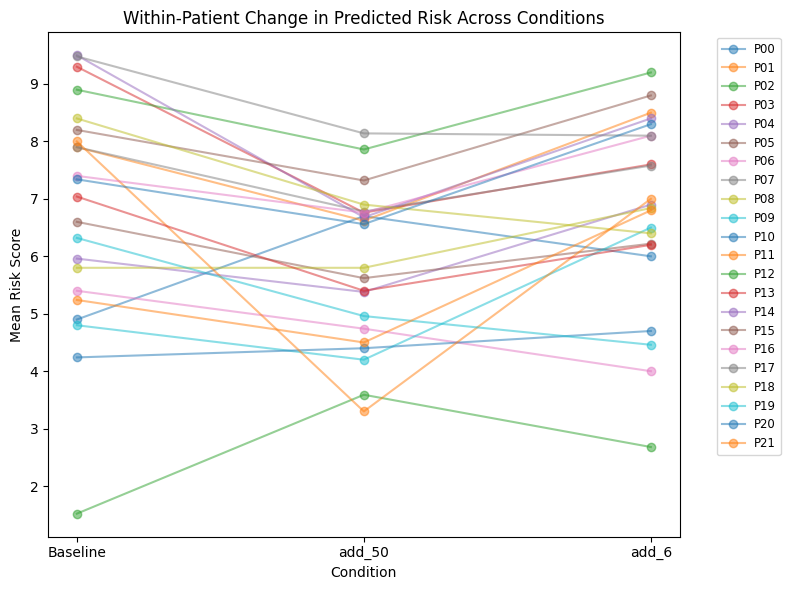

In [15]:

# Compute per-patient means for each condition
summary = df.groupby(["Patient_ID", "Condition"]).agg(
    Mean_Risk=("Risk_Score", "mean")
).reset_index()

plt.figure(figsize=(8,6))
for pid, pdata in summary.groupby("Patient_ID"):
    plt.plot(pdata["Condition"], pdata["Mean_Risk"], marker='o', label=pid, alpha=0.5)

plt.xlabel("Condition")
plt.ylabel("Mean Risk Score")
plt.title("Within-Patient Change in Predicted Risk Across Conditions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


Model is not stable across patients and certain patients are disproportionately affected


SD Bar Chart per Condition
--> Provides quantitative instability evidence.

Range Plot per Patient
--> Shows that instability holds even after accounting for patient-level differences.


   Added_Vars  SD_Abs_Delta_Risk
0           0           0.359134
1           6           1.046802
2          50           1.387819


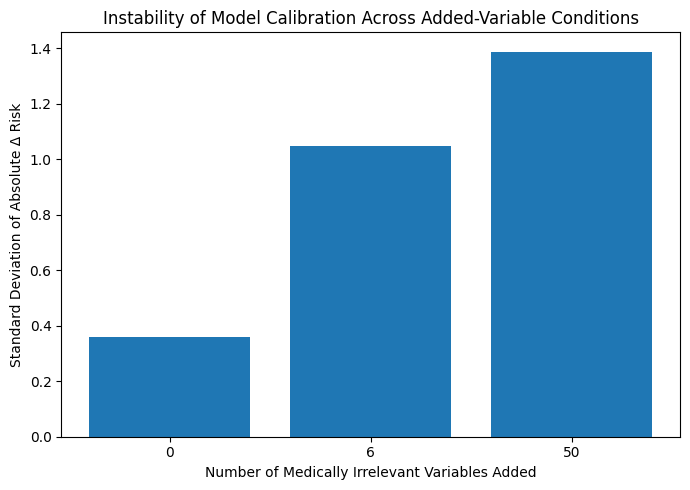

In [19]:
conditions_of_interest = [0, 6, 50]
df_subset = df[df["Added_Vars"].isin(conditions_of_interest)]

# Compute SD of Abs_Delta_Risk for each condition
sd_table = df_subset.groupby("Added_Vars")["Abs_Delta_Risk"].std().reset_index()
sd_table.columns = ["Added_Vars", "SD_Abs_Delta_Risk"]

print(sd_table)

# --- Plot ---
plt.figure(figsize=(7,5))
plt.bar(sd_table["Added_Vars"].astype(str), sd_table["SD_Abs_Delta_Risk"])
plt.xlabel("Number of Medically Irrelevant Variables Added")
plt.ylabel("Standard Deviation of Absolute Δ Risk")
plt.title("Instability of Model Calibration Across Added-Variable Conditions")
plt.tight_layout()
plt.show()

instability caused specifically by added irrelevant information, not on overall noise.

The model becomes inconsistent in how much irrelevant variables push the prediction.

Some trials barely shift the risk score; others shift it a lot. --> Therefore, there is instability in model reasoning (sd of risk scores would show instability of predictions not in relation to the variables added)